## MLP glorified with batch normalization, careful initializations

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2023-10-20 10:09:14--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2023-10-20 10:09:14 (6.07 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)  #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g)  * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g)  * 0.01
b2 = torch.randn(vocab_size,                      generator=g)  #* 0

bnbias = torch.zeros((1,n_hidden))
bngain = torch.ones((1,n_hidden))

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1)
s = embcat @ W1
smeani = s.mean(0, keepdim = True)
sstdi = s.std(0, keepdim = True)
a = (s -smeani)/sstdi
a.std()

tensor(0.9843, grad_fn=<StdBackward0>)

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim = True)
  bnstdi = hpreact.std(0, keepdim = True)
  hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias

  with torch.no_grad():
    bnmean_running = 0.999* bnmean_running + 0.001* bnmeani
    bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  #break

      0/ 200000: 3.8443


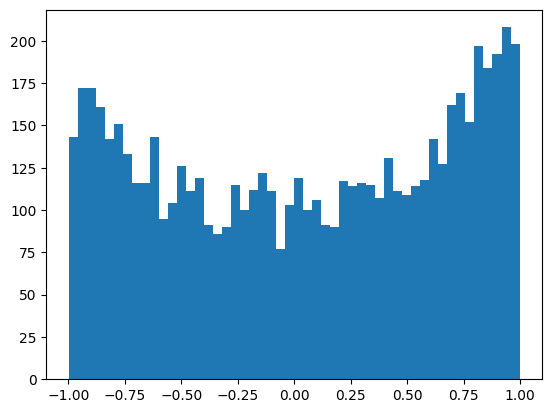

In [ ]:
plt.hist(h.view(-1).tolist(), bins =50);

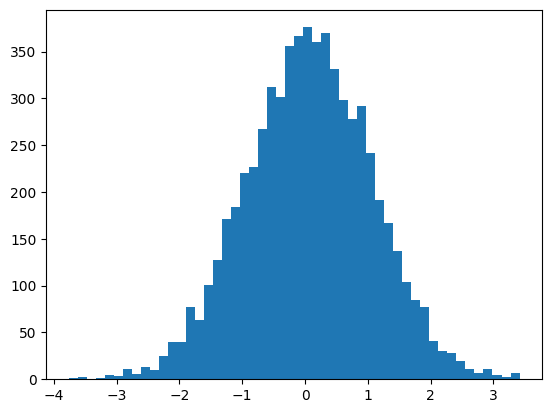

In [ ]:
plt.hist(hpreact.view(-1).tolist(), bins =50);

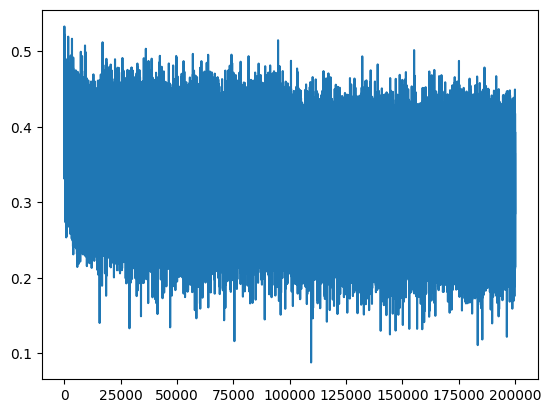

In [ ]:
plt.plot(lossi)

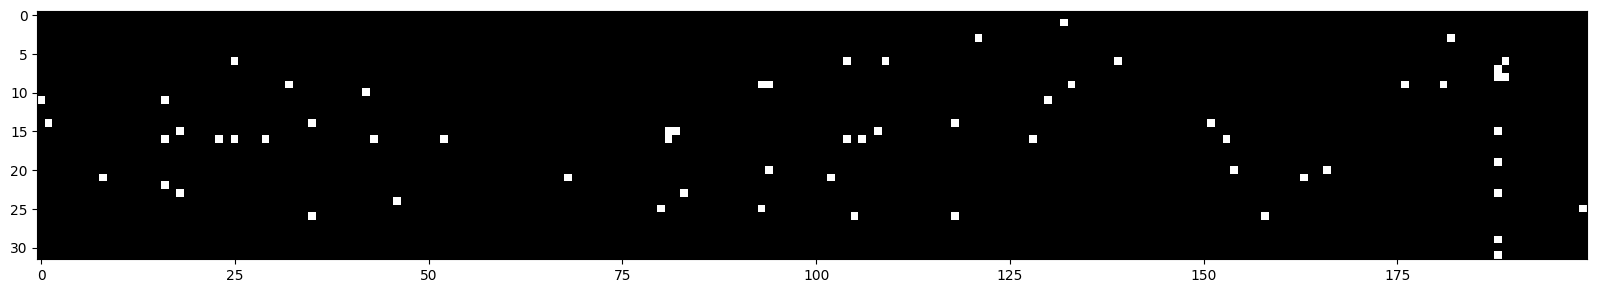

In [ ]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs()>0.99,  cmap = 'gray',interpolation = 'nearest')

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  #+ b1
  hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0624213218688965
val 2.1032140254974365


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1 )# concatenate the vectors
      logits = h @W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
seel.
ndyn.
alerethruthadrie.
cadelyn.
elin.
shi.
jen.
eden.
est.
aarvelyzion.
kamin.
shub.
roshimies.
kin.
renlynn.
novana.
ubeen.
der.


## Even more glorofied . PyTorchified

In [ ]:
class Linear:

  def __init__(self, num_in, num_out, bias = True):
    self.weights = torch.zeros((num_in,num_out)) / num_in**0.5
    self.bias = torch.zeros(num_out) if bias else None


  def __call__(self,x):
    self.out = x @ self.weights
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weights] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, epsilon = 1e-5, momentum = 0.1):
    #parameters
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    #--------------
    self.epsilon = epsilon
    self.momentum = momentum
    #new, same like pytorch
    self.training = True
    #--------------
    #Buffers
    self.running_mean = torch.zeros((1,dim))
    self.running_var = torch.ones((1,dim))
    #---------------

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0,keepdims = True)
      xvar = x.var(0, keepdims = True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    self.out = self.gamma * (self.ws - xmean)/torch.sqrt(xvar + self.epsilon) + self.beta


    if self.training:
      with torch.no_grad():
        self.running_mean = (1- self.momentum) * self.beta + self.momentum * xmean
        self.running_var = (1- self.momentum) * self.gamma + self.momentum * xvar


  def prameters(self):
    return [self.gamma, self.beta]


class Tanh:

  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []




In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility
ud = []

C = torch.randn((vocab_size, n_embd), generator = g)

layers = [
    Linear(3*n_embd, n_hidden),   Tanh(),
    Linear(n_hidden, n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden),  Tanh(),
    Linear(n_hidden, n_hidden),  Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  layers[-1].weights *= 0.1

  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weights *= (5/3)

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters))



for p in parameters:
  p.requires_grad = True

46497


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  #minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)

  # feed forward
  x = C[Xtr[ix]].view(-1,n_embd*block_size)

  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Ytr[ix])

  #backprop
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i>1000:
  #  break



      0/ 200000: 2.8202
  10000/ 200000: 2.8735
  20000/ 200000: 2.9713
  30000/ 200000: 2.7601
  40000/ 200000: 2.9186
  50000/ 200000: 3.0573
  60000/ 200000: 2.6915
  70000/ 200000: 2.5499
  80000/ 200000: 2.6644
  90000/ 200000: 2.8682
 100000/ 200000: 2.5645
 110000/ 200000: 2.9051
 120000/ 200000: 2.5214
 130000/ 200000: 2.9401
 140000/ 200000: 2.6002
 150000/ 200000: 2.6922
 160000/ 200000: 2.8019
 170000/ 200000: 2.9683
 180000/ 200000: 2.6777
 190000/ 200000: 2.6860


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word